In [74]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu


import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def perform_u_tests_log(df, sample_col='sample_type'):
    """
    Perform Mann-Whitney U test for each log2-transformed gene column 
    comparing two sample types (0 vs 1).
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with one column named sample_col (0 or 1) and the rest
        log2-transformed gene expression columns.
    sample_col : str
        Name of the binary group column.
    
    Returns
    -------
    pandas.DataFrame
        Columns: gene, u_stat, p_val, log2fc, corrected_p_val
        Sorted by ascending p_val.
    """
    # identify gene columns
    gene_cols = [c for c in df.columns if c != sample_col]
    
    records = []
    for gene in gene_cols:
        grp0 = df[df[sample_col] == 0][gene]
        grp1 = df[df[sample_col] == 1][gene]
        
        # Mann–Whitney U test (two‐sided)
        u_stat, p_val = mannwhitneyu(grp0, grp1, alternative='two-sided')
        
        # since data are log2-transformed, log2FC = mean₁ − mean₀
        log2fc = grp1.mean() - grp0.mean()
        
        records.append((gene, u_stat, p_val, log2fc))
    
    # build DataFrame
    res = pd.DataFrame(records, columns=['gene', 'u_stat', 'p_val', 'log2fc'])
    
    # FDR correction
    res['corrected_p_val'] = multipletests(res['p_val'], method='fdr_bh')[1]
    
    return res.sort_values('p_val').reset_index(drop=True)

In [75]:
RNA_dat = pd.read_csv("~/Desktop/TCGA.HNSC.expression.txt", sep="\t")
RNA_mtx = RNA_dat.iloc[:, 2:]

In [76]:
# Filter out low expression genes
library_sizes = RNA_mtx.sum(axis=1)
cpm = RNA_mtx.div(library_sizes, axis=0) * 1e6

# at least 3 samples with cpm > 1
min_samples = 3
genes_to_keep_cpm = (cpm > 1).sum(axis=0) >= min_samples

filtered_RNA_mtx = RNA_mtx.loc[:,genes_to_keep_cpm]
filtered_RNA_dat = filtered_RNA_mtx.copy()

RNA_dat.rename(columns={" patient_id": "patient_id"}, inplace=True)
filtered_RNA_dat.insert(0, "sample_id", RNA_dat["sample_id"])
filtered_RNA_dat.insert(0, "patient_id", RNA_dat["patient_id"])

In [77]:
expr_columns = filtered_RNA_dat.columns[2:]
RNA_log_all = filtered_RNA_dat.copy()
RNA_log_all[expr_columns] = filtered_RNA_dat.iloc[:, 2:].applymap(lambda x: np.log2(x + 1))

/var/folders/_k/b8vsv8097ss3sxnsdwkx1y_80000gn/T/ipykernel_7741/2701084133.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  RNA_log_all[expr_columns] = filtered_RNA_dat.iloc[:, 2:].applymap(lambda x: np.log2(x + 1))


In [78]:
sample_encode = RNA_log_all['sample_id'].str.split('-').str[3]
normal_samples = ~sample_encode.str.contains("01")
tumor_samples = ~sample_encode.str.contains("11")
RNA_log_all["sample_type"] = np.where(normal_samples, 0, 1)
deg_tab = RNA_log_all.drop(columns=["sample_id", "patient_id"])
deg_tab

/var/folders/_k/b8vsv8097ss3sxnsdwkx1y_80000gn/T/ipykernel_7741/3714114612.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  RNA_log_all["sample_type"] = np.where(normal_samples, 0, 1)


,?|100133144,?|100134869,?|10357,?|10431,?|155060,?|340602,?|388795,?|391343,?|57714,?|645851,...,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,sample_type
0,2.052764,3.794229,6.953486,10.481860,8.061857,2.568008,2.409717,0.000000,8.114133,2.409717,...,9.443184,4.680859,7.241859,9.517848,3.069513,8.714390,13.503428,9.784995,8.490450,1
1,3.792470,3.678985,8.397311,10.913398,5.333027,0.000000,0.470303,0.000000,7.502705,3.650937,...,10.221756,4.637709,7.436845,8.575055,2.491751,9.654747,11.298022,8.020097,10.089212,1
2,3.735176,2.251749,8.446306,10.544675,6.298598,0.000000,1.051024,0.000000,6.919567,1.051024,...,9.397007,4.453063,7.435037,9.137606,1.382889,8.932923,12.534072,8.197924,9.938555,1
3,3.753102,2.408168,8.124209,10.236995,6.823902,0.000000,2.052555,0.000000,7.368419,2.867244,...,10.013546,5.591724,8.345547,10.493755,5.176195,9.498949,11.385614,9.394840,9.965145,1
4,3.749995,3.656187,8.333357,9.739284,5.618333,0.000000,2.277955,0.000000,8.383756,1.548387,...,10.662944,5.515845,7.726423,10.475733,5.753163,9.592334,12.972371,9.577871,9.438738,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2.181866,3.921227,7.134765,10.103681,8.877990,0.000000,2.838367,0.000000,9.505700,2.674257,...,9.956240,4.589182,7.877517,9.703622,0.822934,9.205659,13.211461,9.504173,9.246418,1
541,3.543780,4.187609,6.757063,10.422654,7.441965,0.000000,0.431463,0.763072,6.450243,3.427539,...,11.149855,4.724890,7.302401,9.547471,8.381629,8.708115,12.378135,10.118733,8.919146,1
542,5.530118,5.209453,7.452134,9.293127,7.681730,0.898324,2.411345,0.000000,9.422269,3.392757,...,10.406141,5.317481,7.952170,10.432083,2.155652,9.104494,11.782511,10.840644,9.476639,1
543,5.821343,5.836331,6.480262,9.807965,8.226219,0.000000,0.000000,0.715278,8.981547,4.702220,...,8.389752,6.040601,8.324815,10.331533,5.599818,11.409322,10.585244,10.912283,9.243800,0


In [79]:
results = perform_u_tests_log(deg_tab, "sample_type")

In [80]:
results

,gene,u_stat,p_val,log2fc,corrected_p_val
0,C14orf180|400258,19959.5,1.760077e-33,-2.302966,3.133993e-29
1,ADIPOQ|9370,21252.0,3.379500e-26,-5.861085,3.008768e-22
2,LACRT|90070,14870.0,1.524668e-25,-0.947714,9.049414e-22
3,GPD1L|23171,22092.0,2.859709e-25,-2.560651,1.272999e-21
4,MGC12982|84793,1071.0,2.388953e-24,2.169992,7.629185e-21
...,...,...,...,...,...
17801,IGFBP4|3487,11474.0,9.980482e-01,-0.127362,9.982724e-01
17802,C17orf101|79701,11475.0,9.988289e-01,-0.041042,9.989411e-01
17803,TBCEL|219899,11479.0,9.988289e-01,0.011114,9.989411e-01
17804,RTN4RL1|146760,11475.5,9.992193e-01,-0.319159,9.992754e-01


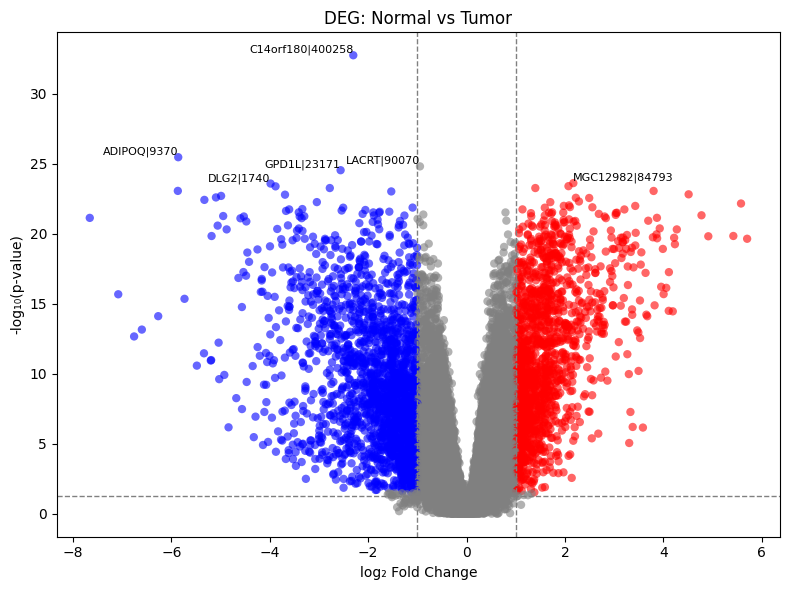

In [94]:
import matplotlib.pyplot as plt

fc_thresh = 1
p_thresh = 0.05

# compute –log10(p‑value)
results['neg_log10_pval'] = -np.log10(results['p_val'])

# helper to assign colors
def volcano_color(log2fc, adj_p):
    if adj_p < p_thresh:
        if log2fc >= fc_thresh:
            return 'red'
        elif log2fc <= -fc_thresh:
            return 'blue'
    return 'grey'

# vectorize color assignment
results['color'] = results.apply(
    lambda row: volcano_color(row['log2fc'], row['corrected_p_val']),
    axis=1
)

top5 = results.nlargest(6, 'neg_log10_pval')

# make the plot
plt.figure(figsize=(8, 6))
plt.scatter(
    results['log2fc'],
    results['neg_log10_pval'],
    c=results['color'],
    alpha=0.6,
    edgecolor='none'
)

# add cutoff lines
plt.axhline(y=-np.log10(p_thresh), color='grey', linestyle='--', linewidth=1)
plt.axvline(x= fc_thresh, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=-fc_thresh, color='grey', linestyle='--', linewidth=1)

for _, row in top5.iterrows():
    plt.text(
        row['log2fc'],
        row['neg_log10_pval'],
        row['gene'],
        fontsize=8,
        ha='right' if row['log2fc'] < 0 else 'left',
        va='bottom'
    )

# labels
plt.xlabel('log₂ Fold Change')
plt.ylabel('-log₁₀(p‑value)')
plt.title('DEG: Normal vs Tumor')
plt.tight_layout()
plt.show()